# Dogs breeds

https://youtu.be/JNxcznsrRb8?t=1h31m8s

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.set_device(1)

Kaggle Dog Breed Identification. Get data from https://www.kaggle.com/c/dog-breed-identification

In [4]:
PATH = "data/drugs/pics/"
sz = 224
arch = resnext101_64
bs = 58

In [5]:


label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [6]:
n

11351

In [7]:
len(val_idxs)

2270

## Initial exploration

In [10]:
!ls {PATH}

labels.csv  models  molecule_pngs.zip  tmp  train


In [11]:
label_df = pd.read_csv(label_csv)

In [12]:
label_df.head()

,class,path
0,reproductivecontrol/139,reproductivecontrol
1,reproductivecontrol/215,reproductivecontrol
2,reproductivecontrol/4,reproductivecontrol
3,reproductivecontrol/135,reproductivecontrol
4,reproductivecontrol/230,reproductivecontrol


In [13]:
label_df.pivot_table(index="path", aggfunc=len).sort_values('class', ascending=False)

,class
path,
antiinfective,3057
cns,2009
antineoplastic,1764
cardio,1605
antiinflammatory,641
gastrointestinal,591
hematologic,510
respiratorysystem,392
reproductivecontrol,245


In [14]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH,'train', f'{PATH}labels.csv',  # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='.png', tfms=tfms, bs=bs)

In [15]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/drugs/pics/train/reproductivecontrol/215.png'

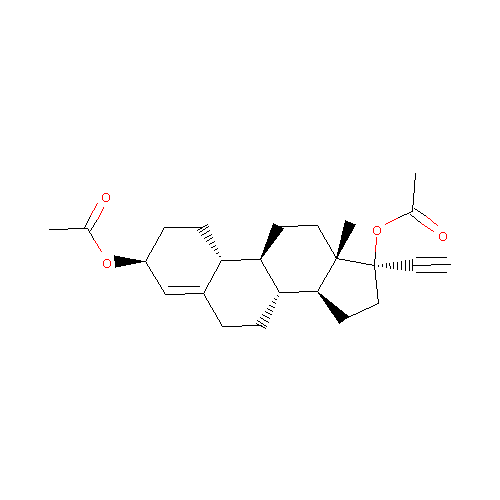

In [16]:
img = PIL.Image.open(fn); img

In [17]:
img.size

(500, 500)

In [18]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [19]:
row_sz, col_sz = list(zip(*size_d.values()))

In [20]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [21]:
row_sz[:5]

array([500, 500, 500, 500, 500])

In [22]:
len(data.classes), data.classes[:5]

(12, ['antiinfective', 'antiinflammatory', 'antineoplastic', 'cardio', 'cns'])

## Initial model

In [23]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',
                                       val_idxs=val_idxs, suffix='.png', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

### Precompute

In [24]:
data = get_data(sz, bs)

In [24]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [28]:
learn.fit(1e-2, 50)

epoch      trn_loss   val_loss   accuracy                    
    0      1.09525    1.276925   0.54978   
    1      1.077343   1.272889   0.55022                     
    2      1.06549    1.259346   0.552863                    
    3      1.046813   1.265766   0.553744                    
    4      1.031208   1.25323    0.555507                     
    5      0.997651   1.267461   0.559471                     
    6      0.975936   1.259652   0.560793                     
    7      0.966657   1.258706   0.559912                     
    8      0.959046   1.274739   0.565198                     
    9      0.950634   1.252039   0.563436                     
    10     0.930773   1.277601   0.562115                     
    11     0.90555    1.28314    0.55815                      
    12     0.897303   1.293536   0.55859                      
    13     0.87758    1.306497   0.544053                     
    14     0.882837   1.279242   0.559031                     
    15     0.86

[array([1.34412]), 0.5621145342152549]

### Augment

In [25]:
from sklearn import metrics

In [26]:
data = get_data(sz, bs)

In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [28]:
learn.fit(1e-2, 20)

epoch      trn_loss   val_loss   accuracy                   
    0      1.947544   1.720529   0.431278  
    1      1.786219   1.586273   0.453744                    
    2      1.703001   1.556203   0.453304                    
    3      1.633139   1.497854   0.474009                    
    4      1.590672   1.455766   0.487665                    
    5      1.550222   1.433725   0.502203                    
    6      1.527202   1.410708   0.495154                    
    7      1.489012   1.378068   0.513216                    
    8      1.435229   1.379444   0.513216                    
    9      1.430674   1.369044   0.520264                    
    10     1.405193   1.355404   0.529075                   
    11     1.392306   1.32671    0.534802                    
    12     1.367224   1.322181   0.535242                    
    13     1.324971   1.32048    0.535242                    
    14     1.298773   1.308027   0.534361                    
    15     1.308057   1.2844

[array([1.27135]), 0.5466960310673399]

In [29]:
learn.precompute = False

In [30]:
learn.fit(1e-2, 5, cycle_len=1)

 11%|█▏        | 18/157 [00:09<01:07,  2.05it/s, loss=1.42]


KeyboardInterrupt: 

In [36]:
learn.save('224_preF_b58')

In [31]:
learn.load('224_preF_b58')

## Find the learning rate

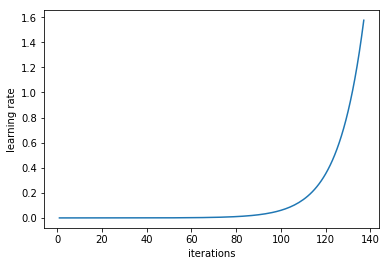

In [39]:
learn.sched.plot_lr()

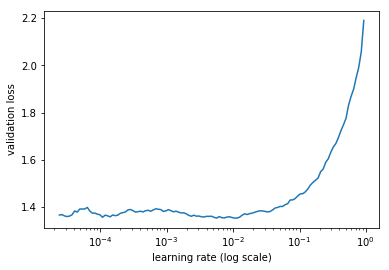

In [40]:
learn.sched.plot()

## Increase size

In [33]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, 80)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

In [34]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

In [35]:
learn.freeze()

In [43]:
learn.fit(5e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.626417   1.426835   0.503524  
    1      1.595296   1.415666   0.511013                   
    2      1.552414   1.397453   0.514097                   


[array([1.39745]), 0.514096918203232]

Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.

In [36]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy                   
    0      1.515581   1.383625   0.522026  
    1      1.507568   1.370226   0.519383                   
    2      1.471789   1.36212    0.52467                    
    3      1.465919   1.36207    0.522026                   
    4      1.451652   1.337367   0.533921                   
    5      1.427047   1.333412   0.53304                    
    6      1.415496   1.328908   0.531278                   



[array([1.32891]), 0.531277537477174]

Training loss and validation loss are getting closer and smaller. We are on right track.

In [37]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.5330396475770925, 1.3259945803139326)

In [38]:
len(data.val_ds.y), data.val_ds.y[:5]

(2270, array([9, 9, 9, 9, 9]))

In [39]:
learn.save('299_pre_bs80')

In [40]:
learn.load('299_pre_bs80')

In [41]:
learn.fit(1e-2, 1, cycle_len=2) # 1+1 = 2 epochs

epoch      trn_loss   val_loss   accuracy                   
    0      1.437424   1.327512   0.537445  
    1      1.412686   1.320846   0.529956                   



[array([1.32085]), 0.5299559487645321]

In [42]:
learn.save('299_pre_bs80')

In [43]:
learn.load('299_pre_bs80')

In [44]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.5259911894273128, 1.3275131736628687)

In [45]:
learn.unfreeze()

In [49]:
lr=np.array([5e-5,5e-4,5e-3])

In [51]:
learn.set_data(get_data(299, 48)) 

 85%|████████▍ | 193/228 [01:58<00:20,  1.67it/s, loss=5.47]

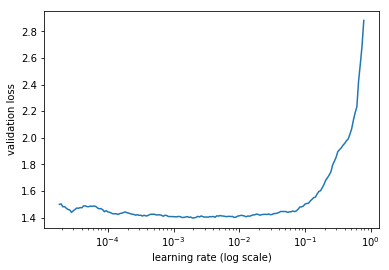

In [48]:
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.448863   1.311074   0.534361  
    1      1.405124   1.303028   0.538767                   
    2      1.396005   1.306464   0.535683                   
 23%|██▎       | 43/190 [00:31<01:42,  1.43it/s, loss=1.39]

In [ ]:
learn.fit(lr, 3000, cycle_len=1, cycle_mult=2)

This dataset is so similar to ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze.

## Create submission

https://youtu.be/9C06ZPF8Uuc?t=1905

In [ ]:
data.classes

In [ ]:
data.test_ds.fnames

In [ ]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)
#accuracy_np(probs, y), metrcs.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [ ]:
probs.shape # (n_images, n_classes)

In [ ]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [ ]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [ ]:
df.head()

In [ ]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [ ]:
FileLink(f'{SUBM}subm.gz')

## Individual prediction

In [ ]:
fn = data.val_ds.fnames[0]
fn

In [ ]:
Image.open(PATH + fn).resize((150, 150))

In [ ]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

In [ ]:
learn.data.classes[np.argmax(preds)]

In [ ]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)